# Stochastic Volatility Inspired Model
------------------
> **Idriss Afra**

This project aims to construct the Equity Implied Volatility surface under the Stochastic Volatility Inspired (SVI) model.

## The SVI Parameterization

The SVI is a parametric model with five parameters per market tenor : $\Gamma_T :=$ {$a, b, \rho, m, \sigma$}. It models the implied total variance :

$$
\sigma_{Imp}^{2}(k, \Gamma_T) . T = \omega(k, \Gamma_T):= a + b × \left[\rho (k - m) + \sqrt{(k-m)^2 + \sigma^2} \space \right]
$$

Where :

$$
k := ln \left( \frac{Strike}{F_T} \right) \in ℝ, \space a ∈ ℝ, \space b ≥ 0, \space |\rho| \lt 1, \space m \in ℝ, \space \sigma \gt 0, \space a + b \sigma \sqrt{1-\rho^2} \ge 0
$$

The last condition ensures that the minimum of the implied total variance is
positive. Note that we choose to use the log-forward moneyness for scaling purposes.

The five parameters control the implied total variance as follows :
* $a$ : Determines the overall level of total variance. Increasing $a$ increases the general level of
variance by a vertical translation of the smile.
* $b$ : Controls the angle between the left and right asymptotes (Convexity). Increasing $b$ tights the smile.
* $\rho$ : Determines the orientation of the graph. Increasing $\rho$ forces a counter-clockwise rotation of the smile.
* $m$ : Forces a horizontal translation of the smile. Increasing $m$ translates the smile to the right.
* $\sigma$ : Determines the curvature of the smile. Increasing $\sigma$ reduces the at-the-money (ATM) curvature
of the smile.

In [1]:
import numpy as np

def svi_v2T(k, a, b, rho, m, sigma) :
    """
    V2T formula under the SVI model.
    The log-moneyness k can be a scalar or an array, the function will return the SVI total variances.
    """
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma **2))

def svi_vol(k, a, b, rho, m, sigma, T) :
    """
    The SVI implied volatilities.
    The log-moneyness k can be a scalar or an array.
    """
    v2T = svi_v2T(k, a, b, rho, m, sigma)
    return np.sqrt(v2T / T)

## The Butterfly Arbitrage

In order to ensure the Butterfly free-arbitrage under the SVI model, the  probability density function of $S_T$ needs to be non-negative :

$$
f_{S_T}(K) = e^{rT} × \frac{d^2C_{BS}(K, T)}{dK^2}\gt 0
$$

And hence :

$$
p(k) := \frac{d^2C_{BS}(k, \omega(k, \Gamma_T))}{dK^2}\gt 0
$$

Where :

$$
\begin{align}
C_{BS}(k, \omega(k, \Gamma_T)) & = S e^{-qT} × \left(N(d_1) - e^k N(d_2)\right) \\
d_1 & = \frac{-k + ω(k, Γ_T) / 2}{\sqrt{ω(k, Γ_T)}} \\
d_2 & = d_1 - \sqrt{ω(k, Γ_T)}
\end{align}
$$

By differentiating the above Black-Scholes formula for any $k \in ℝ$, we get :
$$
p(k) = \frac{g(k)}{\sqrt{2Π.ω(k, Γ_T)}} × e^{-\frac{d_2^2}{2}}
$$
Where :
$$
g(k) := \left(1- \frac{k.ω'(k, Γ_T)}{2.ω(k, Γ_T)}\right)^2 - \frac{ω'(k, Γ_T)^2}{4} × \left( \frac{1}{ω(k, Γ_T)} + \frac{1}{4}\right) + \frac{ω''(k, Γ_T)}{2}
$$

<br>Therefore, the Butterfly free-arbitrage condition is : $ g(k) > 0 $



## Volatility on the Wings

To guarantee the Butterfly free-arbitrage, we should focus on the wings. In fact, we need to ensure that the  probability density function of $S_T$, and hence $g(k)$, are non-negative for extreme strikes.

Since :
* For ${k \to +∞}$ : $\omega_R(k, Γ_T) ≈ b(\rho + 1)k + [a-bm(\rho + 1)] $
* For ${k \to -∞}$ : $\omega_L(k, Γ_T) ≈ b(\rho - 1)k + [a-bm(\rho - 1)] $

Then for extreme strikes, $g(k)$ turns to the following quadratic equation :
$$
g(k) ≈ \frac{\beta^2}{4} \left(1 - \frac{\beta^2}{4}\right) k^2 + \frac{1}{4} \left(4\alpha\beta - \beta^3 - \frac{\alpha\beta^3}{2}\right) k + \frac{1}{4} \left(4\alpha^2 - \alpha\beta^2 - \frac{\alpha^2\beta^2}{4}\right)
$$
Where:
* For ${k \to +∞}$ : $\alpha=a - bm(\rho + 1)$ and $\beta=b(\rho + 1)$
* For ${k \to -∞}$ : $\alpha=a - bm(\rho - 1)$ and $\beta=b(\rho - 1)$

We avoid the arbitrage by considering that the discriminants $Δ_R$ and $Δ_L$ are negative and that $\frac{\beta^2}{4} \left(1 - \frac{\beta^2}{4}\right) \gt 0$. These conditions implies the following constraints :
* Constraint 1 : $(a-mb(\rho+1))(4-a+mb(\rho+1))-b^2(\rho+1)^2 > 0$
* Constraint 2 : $(a-mb(\rho-1))(4-a+mb(\rho-1))-b^2(\rho-1)^2 > 0$
* Constraint 3 : $0 < b^2(\rho+1)^2 < 4$
* Constraint 4 : $0 < b^2(\rho-1)^2 < 4$

## The Calendar Arbitrage

In order to ensure the Calendar free-arbitrage under the SVI model, we will need to add the following constraints for all the quoted tenors $(T_i)_{1\le i \le n}$ : $ω(k, Γ_{T_i}) > ω(k, Γ_{T_{i-1}})$

In practice, we will ensure that this inequality holds for moneyness ranging from $50\%$ to $150\%$, as this is typically the moneyness range of instruments used for pricing model calibration.


## SVI Model Calibration

The calibration of the SVI model goes through a minimization process with the objective of replicating the market implied total variances.

For each market tenor $T$ :
$$
\Gamma_T \left( a^T, b^T, \rho^T, m^T, \sigma^T \right) = ArgMin_{(a, b, \rho, m, \sigma)} \frac{1}{N_T} ∑_{K_i ∈ Market}\left|\omega(k, \Gamma_T) - (\sigma_{K_i, T}^{Market}\sqrt{T})^2 \right|
$$

## SVI's Parameters Boundaries

We determine lower and upper boundaries for each SVI parameters in order to run
an efficient calibration that respects conditions related to the model and to avoid arbitrages :

* Parameter $a$ :
The minimum of the SVI total variance is located at the point : $ k^* = m - \frac{\rho \sigma}{\sqrt{1 - \rho^2}} $, and its value is : $ w_{min}(k) = a + b \sigma \sqrt{1 - \rho^2} $. Therefore, we must ensure that : $ a + b \sigma \sqrt{1 - \rho^2} > 0 $. We choose the following stronger condition : $ a > 0 $.
Finally, we can conclude that the condition on $a$ is : $
0 < 10^{-5} \le a \le max({w}^{market}) $

* Parameter $\rho$ :
The correlation coefficient must be in the interval : $ ]-1 , 1[ $

* Parameter $m$ :
This parameter controls the horizontal translation of the smiles. Therefore, we can floor and cap it with the following reasonable levels : $
2 \times min_i({k_i}^{market}) \le m \le 2 \times max_i({k_i}^{market})$

* Parameter $\sigma$ :
The parameter $\sigma$ should not take large value to ensure the curvature of the smiles near the ATM. Therefore, we can choose the following boundaries : $0.01 \le \sigma \le 1$

* Parameter $b$ :
Since the call prices convert to $0$ when $k$ tends to $+∞$, $d_1(k)$ must convert to $-∞$ when $k$ tends to $+∞$ (Rogers' Lemma).
In this case: $
lim_{k \to +∞} \frac{-k}{\sqrt{w(k)}} + \frac{\sqrt{w(k)}}{2} = -∞
$ 
Therefore : $
limsup_{k \to +∞} \frac{w(k)}{2k} = \frac{b (\rho + 1)}{2} \lt 1
$ 
To ensure the above equations, $b$ must respect the following conditions : $
10^{-3} \le b \lt 1 $

## SVI Model Implementation

In [2]:
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

def svi_calibration(T, k, v2T) :
    """
    SVI model calibration : The function will return the calibrated SVI total variances.
    The argument T can be a scalar or an array.
    The constraints functions ensure the Calendar Spread and the Butterfly free-arbitrages.
    """
    if type(T) == int or type(T) == float :
        # SVI calibration on a single market tenor
        parameters0 = np.array([min(v2T), 0.5, -0.2, 0.1, 0.2]) # a, b, rho, m, sigma : Chosen arbitrary
        constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, 
                       {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4})
        res = minimize(obj_func, x0=parameters0, args=(k, v2T), 
                       bounds=((1e-05, max(v2T)), (1e-03, 0.99), (-0.99, 0.99), (2*min(k), 2*max(k)), (1e-02, 0.99)), 
                       constraints=constraints, options={"maxiter" : 1000}, tol=1e-8)
        return res.x
    else :
        # SVI calibration on a set of market tenors
        parameters0 = np.array([min(v2T[0]) / 2, 0.5, -0.2, 0.1, 0.2]) # a, b, rho, m, sigma : Chosen arbitrary
        constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, 
                       {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4})
        res = minimize(obj_func, x0=parameters0, args=(k[0], v2T[0]), 
                       bounds=((1e-05, max(v2T[0])), (1e-03, 0.99), (-0.99, 0.99), (2*min(k[0]), 2*max(k[0])), (1e-02, 0.99)), 
                       constraints=constraints, options={"maxiter" : 1000}, tol=1e-8)
        results = [res.x]
        for i in range(1, len(T)) :
            parameters0 = np.array([min(v2T[i]) / 2, 0.5, -0.2, 0.1, 0.2]) # a, b, rho, m, sigma : Chosen arbitrary
            constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, 
                           {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4}, 
                           {'type': 'ineq', 'fun':constraint5, 'args': (k[i], k[i-1], results[i-1])})
            res = minimize(obj_func, x0=parameters0, args=(k[i], v2T[i]), 
                           bounds=((1e-05, max(v2T[i])), (1e-03, 0.99), (-0.99, 0.99), (2*min(k[i]), 2*max(k[i])), (1e-02, 0.99)), 
                           constraints=constraints, options={"maxiter" : 1000}, tol=1e-8)
            results.append(res.x)
        return results

def obj_func(parameters, k, v2T) :
    """
    The objective function of the SVI calibration : Sum-Squared Error (SSE) minimization between SVI and market total variances
    """
    svi  = svi_v2T(k, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
    sse = 0
    for i in range(len(k)) :
        sse += abs(svi[i] - v2T[i])
    return 10000 * sse / len(k)

def constraint1(parameters):
    """
    1st constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2 - eps

def constraint2(parameters):
    """
    2nd constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2 - eps

def constraint3(parameters):
    """
    3th constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return 4 - b**2 * (rho + 1)**2 - eps

def constraint4(parameters):
    """
    4th constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return 4 - b**2 * (rho - 1)**2 - eps

def constraint5(parameters, k_current, k_previous, params_previous):
    """
    5th constraint : Calendar Spread Arbitrage-Free
    """
    log_moneyness = np.log(np.arange(0.5, 1.6, 0.0001))
    log_moneyness = np.concatenate((k_current, k_previous,log_moneyness))
    log_moneyness = np.unique(np.sort(log_moneyness))
    v2T_previous = svi_v2T(log_moneyness, params_previous[0], params_previous[1], params_previous[2], 
                           params_previous[3], params_previous[4])
    v2T  = svi_v2T(log_moneyness, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
    return -1 if (False in (v2T_previous < v2T)) else 1


## Application : CAC40 Listed Index Options

Now, let's apply the SVI model to construct the CAC40 implied volatility surface. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, computed in the following project : [Equity Implied Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Volatility%20Surface.ipynb).

In [3]:
import datetime
import pandas as pd
from scipy.interpolate import interp1d

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")

eq_underlying = "CAC40"
S0 = 8042.19
print(eq_underlying + " Close Price : ", S0)
print("-----------------------------------------------")

option_data = pd.read_csv("MarketData/" + eq_underlying + "_MarketData_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(eq_underlying + " Option Data :")
print(option_data)
print("-----------------------------------------------")

rate_underlying = "EURIBOR6M"
print(rate_underlying + " Zero-Coupon Rate Curve :")
rates_data = pd.read_csv("MarketData/" + rate_underlying +  "_ZCRates_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(rates_data)

# ZC Rate : Cubic Interpolation & Extrapolation
zc_rate = interp1d(rates_data['Expiry'], rates_data['ZCRate'], kind='cubic', fill_value="extrapolate")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :
       Expiry   Strike    Call      Put  Dividend    Forward  Volatility
0    0.024658   7925.0  151.83    27.92  0.000000  8048.9990    0.147886
1    0.024658   7950.0  132.52    33.59  0.000000  8048.9990    0.144939
2    0.024658   7975.0  114.13    40.18  0.000000  8048.9990    0.141802
3    0.024658   8000.0   96.79    47.82  0.000000  8048.9990    0.138507
4    0.024658   8025.0   81.15    57.17  0.000000  8048.9990    0.136136
..        ...      ...     ...      ...       ...        ...         ...
137  4.857534   8000.0  977.10  1115.35  0.026932  7847.4929    0.168488
138  4.857534   8400.0  808.07  1308.91  0.026932  7847.4929    0.163171
139  4.857534   8800.0  665.26  1528.71  0.026932  7847.4929    0.159247
140  4.857534   9600.0  450.36  2039.01  0.026932  7847.4929    0.154873
141  4.857534  10400.0  

First, let's gather the data and store it in global dictionaries:

In [4]:
def collect_data(option_data):
    """
    Collects data and store it in dictionaries.
    """
    implied_divs, implied_forwards, strikes, implied_vols  = dict(), dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        implied_divs[exp] = float(np.unique(df['Dividend']))
        implied_forwards[exp] = float(np.unique(df['Forward']))
        df = df.sort_values(by=['Strike'])
        strikes[exp], implied_vols[exp] = list(df['Strike']), list(df['Volatility']) 
    return {"Dividends" : implied_divs, "Forwards" : implied_forwards, "Strikes" : strikes, "Volatilities" : implied_vols}    

# Collected Data
data = collect_data(option_data)
implied_divs = data["Dividends"]
implied_forwards = data["Forwards"]
market_expiries = list(implied_forwards.keys())
strikes = data["Strikes"]
implied_vols = data["Volatilities"]

# Dividend Yield function : Piece-Wise Interpolation / Extrapolation
div_func = interp1d([0] + market_expiries, list(implied_divs.values()) + [list(implied_divs.values())[-1]], 
                    kind='previous', fill_value="extrapolate")

Then, let's clean the data and calibrate the SVI on the listed expiries:


SVI Total Variance Skews :


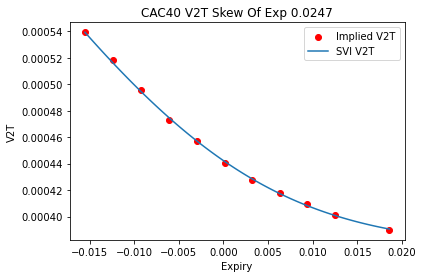

=> Convergence Error :  0.0
-----------------------------------------------------------


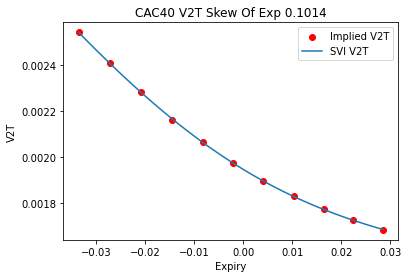

=> Convergence Error :  0.0
-----------------------------------------------------------


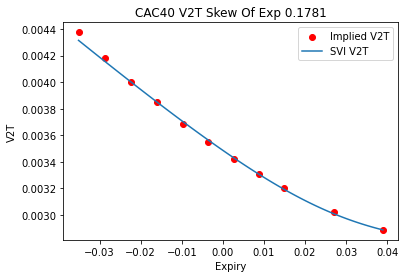

=> Convergence Error :  0.0
-----------------------------------------------------------


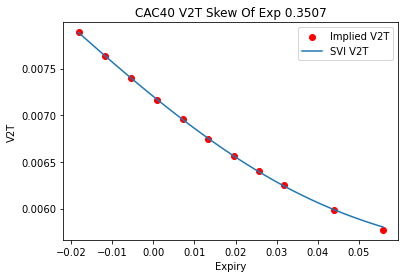

=> Convergence Error :  0.0
-----------------------------------------------------------


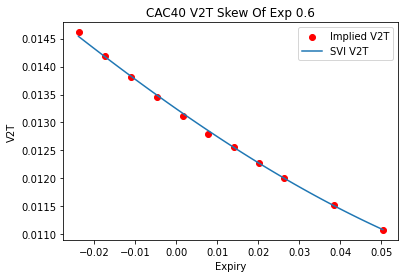

=> Convergence Error :  0.0
-----------------------------------------------------------


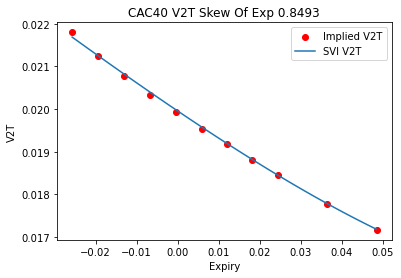

=> Convergence Error :  0.0
-----------------------------------------------------------


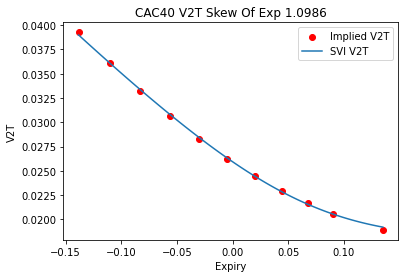

=> Convergence Error :  0.0001
-----------------------------------------------------------


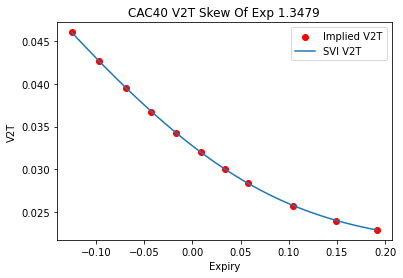

=> Convergence Error :  0.0
-----------------------------------------------------------


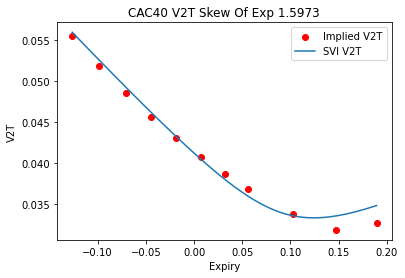

=> Convergence Error :  0.0008
-----------------------------------------------------------


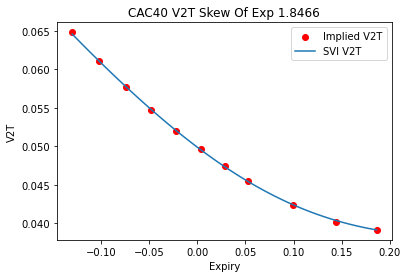

=> Convergence Error :  0.0001
-----------------------------------------------------------


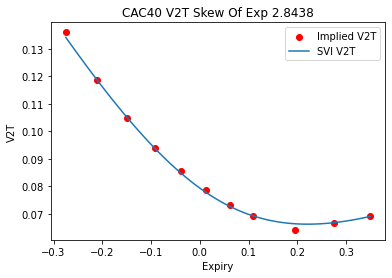

=> Convergence Error :  0.0006
-----------------------------------------------------------


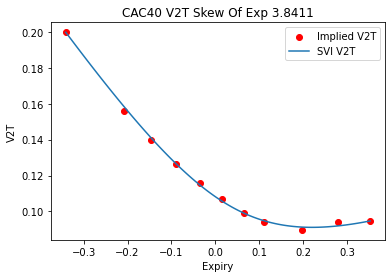

=> Convergence Error :  0.0009
-----------------------------------------------------------


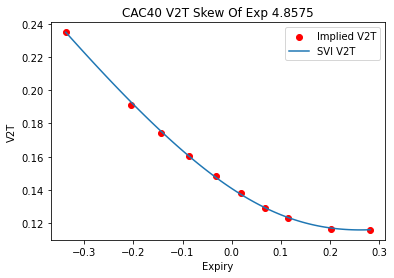

=> Convergence Error :  0.0005
-----------------------------------------------------------


In [5]:
from scipy.stats import norm
import matplotlib.pyplot as plt

def exercise_probability(exp, forward, strike, vol):
    """
    Computes the Black exercise probability.
    """
    phi = 1 if (strike > forward) else -1 # OTM Calls / Puts
    sqrt_v2T = np.sqrt(vol**2 * exp)
    d2 = np.log(forward / strike) / sqrt_v2T - 0.5 * sqrt_v2T
    return norm.cdf(phi * d2)
    

def clean_data(exp, forward, strikes, vols, min_moneyness = 0.5, max_moneyness = 1.5, min_exercise_proba=0.05, 
               max_exercise_proba=0.95):
    """
    Cleans the data before SVI calibration.
    The filters are based on moneyness and execise probabilities.
    """
    keep_index = [i for i in range(len(strikes)) if 
                 (strikes[i] / forward >= min_moneyness) and (strikes[i] / forward <= max_moneyness) and
                 exercise_probability(exp, forward, strikes[i], vols[i]) >= min_exercise_proba and 
                 exercise_probability(exp, forward, strikes[i], vols[i]) <= max_exercise_proba]
    nb_cleaned_data = len(strikes) - len(keep_index)
    word = " was " if nb_cleaned_data == 1 else "s were "
    if nb_cleaned_data > 0 : print("/!\ " + str(nb_cleaned_data) + " strike" + word + "cleaned.")
    return np.log(np.array([strikes[i] for i in keep_index]) / forward), np.array([vols[i] for i in keep_index])**2 * exp

k = []
v2T = []
for exp in market_expiries:
    cleaned_strikes, cleaned_v2T = clean_data(exp, implied_forwards[exp], strikes[exp], implied_vols[exp])
    k.append(cleaned_strikes)
    v2T.append(cleaned_v2T)
    
params = svi_calibration(market_expiries, k, v2T)
svi_params = dict()
print("\nSVI Total Variance Skews :")
for i in range(len(market_expiries)):
    exp = market_expiries[i]
    svi_params[exp] = params[i]
    plt.title(eq_underlying + " V2T Skew Of Exp " + str(round(exp, 4)))
    plt.ylabel("V2T")
    plt.xlabel("Expiry") 
    plt.scatter(k[i], v2T[i], color="red", label="Implied V2T")
    x_axis = np.linspace(k[i][0], k[i][-1], 100)
    v2T_func = svi_v2T(x_axis, svi_params[exp][0], svi_params[exp][1], svi_params[exp][2], svi_params[exp][3], 
                       svi_params[exp][4])
    plt.plot(x_axis, v2T_func, label="SVI V2T")
    plt.legend(loc="upper right")
    plt.show()
    print("=> Convergence Error : ", round(obj_func(svi_params[exp], k[i], v2T[i]) / 10000, 4))
    print("-----------------------------------------------------------")

Finally, we construct the SVI implied V2T surface:

In [6]:
def implied_v2T(T, k, svi_params, interp_meth='linear', min_moneyness = 0.5, max_moneyness = 1.5):
    """
    SVI implied v2T.
    Expiry : Linear V2T interpolation - Flat Vol extrapolation.
    Strike : SVI V2T formula on [50% - 150%] - Flat vol extrapolation (To avoid the SVI linear 
    divergence on extreme strikes).
    """
    k = min(np.log(max_moneyness), max(np.log(min_moneyness), k))
    if (T <= market_expiries[0]) or (T >= market_expiries[-1]) or (T in market_expiries):
        exp = market_expiries[0] if (T <= market_expiries[0]) else \
             (market_expiries[-1] if (T >= market_expiries[-1]) else T)
        return svi_v2T(k, svi_params[exp][0], svi_params[exp][1], svi_params[exp][2],
                       svi_params[exp][3], svi_params[exp][4])
    else:
        expiries = market_expiries + [T]
        expiries.sort()
        index = expiries.index(T)
        # Prev
        T_prev = expiries[index - 1]
        svi_params_prev = svi_params[T_prev]
        v2T_prev = svi_v2T(k, svi_params[T_prev][0], svi_params[T_prev][1], 
                           svi_params[T_prev][2], svi_params[T_prev][3], svi_params[T_prev][4])
        # Next
        T_next = expiries[index + 1]
        svi_params_next = svi_params[T_next]
        v2T_next = svi_v2T(k, svi_params[T_next][0], svi_params[T_next][1], 
                           svi_params[T_next][2], svi_params[T_next][3], svi_params[T_next][4])
        # Linear V2T
        return  interp1d([T_prev, T_next], [v2T_prev, v2T_next], kind=interp_meth)(T)


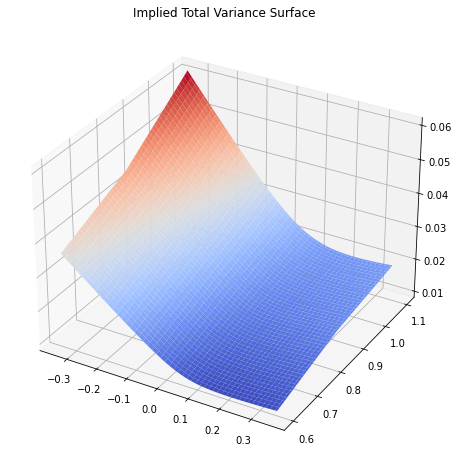

In [7]:
from matplotlib import cm

plt.rcParams["figure.figsize"] = (11,8)

K_min = min([min(np.log(np.array(strikes[exp]) / implied_forwards[exp])) for exp in market_expiries])
K_max = max([max(np.log(np.array(strikes[exp]) / implied_forwards[exp])) for exp in market_expiries])
K = np.linspace(K_min, K_max, 100)
T = np.linspace(market_expiries[4], market_expiries[6], 100)
K, T = np.meshgrid(K, T)

def vol(K, T):
    vols = np.zeros(shape=K.shape)
    for t in range(vols.shape[0]):
        for k in range(vols.shape[1]):
            vols[t, k] = implied_v2T(T[t][k], K[t][k], svi_params)
    return vols

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(K, T, vol(K, T), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Implied Total Variance Surface")
plt.show()